# 2.2 - Ajuste Supervisado

### GridSearching  -  CrossValidation


![grid](images/grid.png)

![cv](images/cv.ppm)

In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np


from sklearn.datasets import make_circles, load_boston

from sklearn.model_selection import train_test_split as tts

from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import RandomForestClassifier as RFC

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [11]:
#help(RFR)

In [15]:
def grid(modelo, param, cv=5):
    
    g=GridSearchCV(modelo,   # modelo de sklearn
                   param,    # parametros, diccionario
                   cv=cv,    # cross-validation, 5 cortes(20%), train_test_split
                   return_train_score=True,  # para ver el error en el paquete de train
                   n_jobs=-1)  # para todas las cpus
                  
    
    g.fit(X_train, y_train)
    
    print('Acierto test: {:.2f}'.format(g.score(X_test, y_test)))
    print('Acierto train: {:.2f}'.format(g.score(X_train, y_train)))
    print('Mejores parametros: {}'.format(g.best_params_))
    print('Mejor acierto cv: {:.2f}'.format(g.best_score_))
    
    return g.best_estimator_.fit(X_train, y_train)  # mejor modelo encontrado ya entrenado

In [7]:
X_train, X_test, y_train, y_test = tts(load_boston().data, 
                                       load_boston().target, test_size=.2)

In [17]:
%%time

rfr=RFR()

rfr.fit(X_train, y_train)


train_score=rfr.score(X_train, y_train)    # R2
test_score=rfr.score(X_test, y_test)

print (train_score, test_score)

0.9836846885787353 0.8597771953558406
CPU times: user 180 ms, sys: 3.48 ms, total: 183 ms
Wall time: 181 ms


In [12]:
param={'n_estimators': [10, 50, 100, 150, 500],
       'max_depth': [1, 5, 10, 15, 20]}

In [16]:
%%time

grid(rfr, param)

Acierto test: 0.86
Acierto train: 0.99
Mejores parametros: {'max_depth': 15, 'n_estimators': 100}
Mejor acierto cv: 0.88
CPU times: user 390 ms, sys: 16.8 ms, total: 407 ms
Wall time: 4.75 s


RandomForestRegressor(max_depth=15)

In [20]:
modelo=grid(rfr, param)

Acierto test: 0.85
Acierto train: 0.98
Mejores parametros: {'max_depth': 10, 'n_estimators': 100}
Mejor acierto cv: 0.88


In [19]:
modelo.predict(X_test)[:5]

array([25.9082 , 29.3028 , 16.9786 , 24.19525, 12.1612 ])

### Random GridSearching

In [27]:
X, y = make_circles(noise=0.2, factor=0.5, random_state=1)

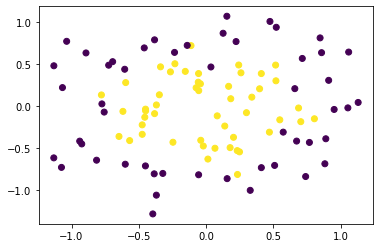

In [28]:
import pylab as plt

plt.scatter(X[::, 0], X[::, 1], c=y);

In [30]:
n_estimators=[int(x) for x in np.linspace(200, 2000, 10)]

max_features=['auto', 'sqrt']

min_samples_split=[2, 5, 10]

bootstrap=[True, False]

In [31]:
params={'n_estimators': n_estimators,
        'max_features': max_features,
        'min_samples_split':min_samples_split,
        'bootstrap': bootstrap}

In [32]:
rfc=RFC()

In [34]:
rf_random=RandomizedSearchCV(estimator=rfc,
                             param_distributions=params,
                             n_iter=100,
                             cv=3,
                             verbose=10,
                             n_jobs=-1,
                             scoring='roc_auc')

In [35]:
rf_random.fit(X, y)   # ajustate para el mejor modelo

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   scoring='roc_auc', verbose=10)

In [37]:
rf_random.best_estimator_.fit(X, y)   # entrenar el mejor modelo

RandomForestClassifier(max_features='sqrt', n_estimators=400)

In [38]:
rf_random.best_score_

0.8858491926182238

In [39]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'max_features': 'sqrt',
 'bootstrap': True}

### HyperOpt (GridSearching bayesiano)

In [ ]:
!pip install hyperopt

In [40]:
import pandas as pd
from pandas.plotting import scatter_matrix

import statsmodels.api as sm
from statsmodels.formula.api import ols

import xgboost as xgb

from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK

from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split as tts

In [41]:
df=pd.read_csv('../data/diamonds_train.csv')
df=df.dropna()

df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.21,Premium,J,VS2,62.4,58.0,4268,6.83,6.79,4.25
1,0.32,Very Good,H,VS2,63.0,57.0,505,4.35,4.38,2.75
2,0.71,Fair,G,VS1,65.5,55.0,2686,5.62,5.53,3.65
3,0.41,Good,D,SI1,63.8,56.0,738,4.68,4.72,3.00
4,1.02,Ideal,G,SI1,60.5,59.0,4882,6.55,6.51,3.95


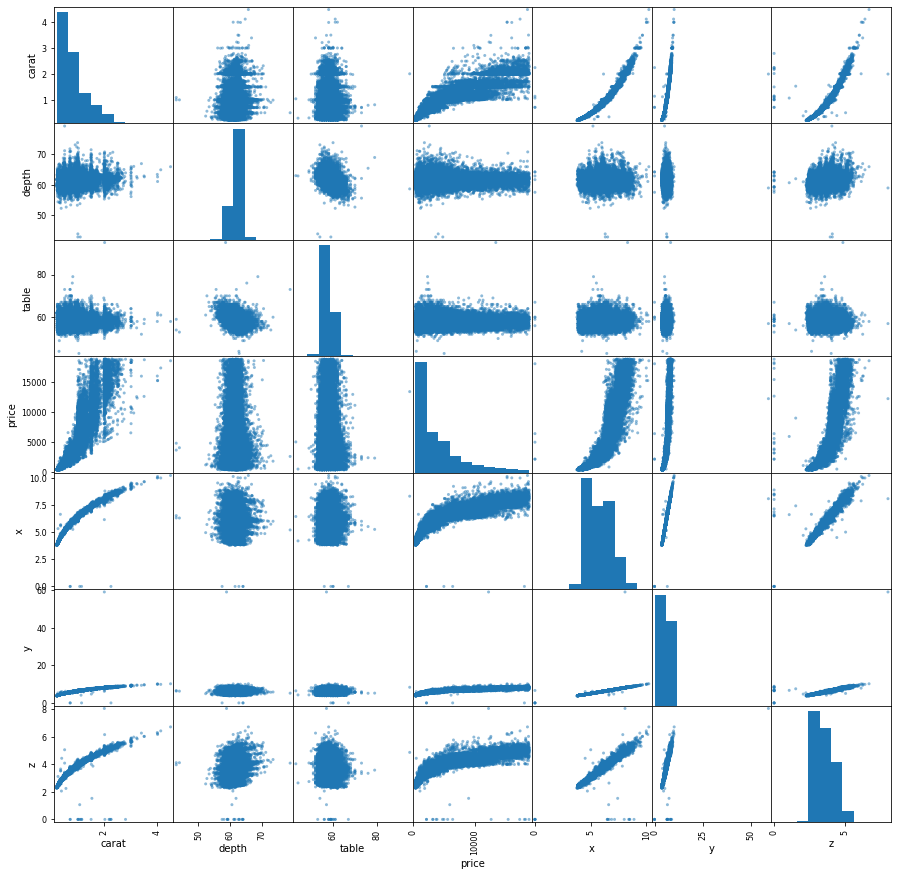

In [42]:
scatter_matrix(df, figsize=(15, 15));

In [43]:
X=df.drop('price', axis=1)

y=df.price

In [45]:
x=sm.add_constant(X._get_numeric_data())  # regresion lineal

modelo=sm.OLS(y, x).fit()

In [46]:
pred=modelo.predict(x)

modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                 4.136e+04
Date:                Tue, 20 Sep 2022   Prob (F-statistic):               0.00
Time:                        12:00:58   Log-Likelihood:            -3.5311e+05
No. Observations:               40455   AIC:                         7.062e+05
Df Residuals:                   40448   BIC:                         7.063e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.152e+04    576.435     37.339      0.000    2.04e+04    2.27e+04
carat       1.067e+04     73.530    145.064      0.000    1.05e+04    1.08e+04
depth       -214.5839      7.619    -28.166      0.000    -229.516    -199.651
table       -101.8176      3.555    -28.639      0.000    -108.786     -94.849
x          -1343.8074     62.684    -21.438      0.000   -1466.669   -1220.946
y             42.9796     29.273      1.468      0.142     -14.396     100.355
z            126.9522     88.089      1.441      0.150     -45.705     299.609
==============================================================================
Omnibus:                    10240.714   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           241364.592
Skew:                           0.670   Prob(JB):                         0.00
Kurtosis:                      14.891   Cond. No.                     6.62e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

[CV 2/3; 1/100] START bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=200
[CV 2/3; 1/100] END bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=200;, score=0.884 total time=   0.2s
[CV 2/3; 5/100] START bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=800
[CV 2/3; 5/100] END bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=800;, score=0.873 total time=   0.5s
[CV 3/3; 7/100] START bootstrap=True, max_features=auto, min_samples_split=10, n_estimators=600
[CV 3/3; 7/100] END bootstrap=True, max_features=auto, min_samples_split=10, n_estimators=600;, score=0.960 total time=   0.4s
[CV 1/3; 8/100] START bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=1400
[CV 1/3; 8/100] END bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=1400;, score=0.806 total time=   0.7s
[CV 2/3; 12/100] START bootstrap=False, max_features=sqrt, min_samples_split=5, n_estimators=1800
[CV 2/3; 12/

[CV 3/3; 2/100] START bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=200
[CV 3/3; 2/100] END bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=200;, score=0.881 total time=   0.1s
[CV 3/3; 3/100] START bootstrap=True, max_features=sqrt, min_samples_split=5, n_estimators=2000
[CV 3/3; 3/100] END bootstrap=True, max_features=sqrt, min_samples_split=5, n_estimators=2000;, score=0.956 total time=   1.3s
[CV 2/3; 10/100] START bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=600
[CV 2/3; 10/100] END bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=600;, score=0.842 total time=   0.3s
[CV 3/3; 10/100] START bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=600
[CV 3/3; 10/100] END bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=600;, score=0.886 total time=   0.3s
[CV 1/3; 13/100] START bootstrap=True, max_features=sqrt, min_samples_split=10, n_estimators=2000
[CV 1/

[CV 1/3; 1/100] START bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=200
[CV 1/3; 1/100] END bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=200;, score=0.817 total time=   0.1s
[CV 3/3; 4/100] START bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=400
[CV 3/3; 4/100] END bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=400;, score=0.884 total time=   0.2s
[CV 2/3; 6/100] START bootstrap=True, max_features=auto, min_samples_split=10, n_estimators=2000
[CV 2/3; 6/100] END bootstrap=True, max_features=auto, min_samples_split=10, n_estimators=2000;, score=0.860 total time=   1.3s
[CV 3/3; 6/100] START bootstrap=True, max_features=auto, min_samples_split=10, n_estimators=2000
[CV 3/3; 6/100] END bootstrap=True, max_features=auto, min_samples_split=10, n_estimators=2000;, score=0.960 total time=   1.3s
[CV 3/3; 15/100] START bootstrap=True, max_features=sqrt, min_samples_split=5, n_estimators=1200
[CV 3/3; 

In [47]:
X=X.drop(['y', 'z'], axis=1)

In [48]:
x=sm.add_constant(X._get_numeric_data())  # regresion lineal

modelo=sm.OLS(y, x).fit()

pred=modelo.predict(x)

modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                 6.204e+04
Date:                Tue, 20 Sep 2022   Prob (F-statistic):               0.00
Time:                        12:02:40   Log-Likelihood:            -3.5312e+05
No. Observations:               40455   AIC:                         7.062e+05
Df Residuals:                   40450   BIC:                         7.063e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.112e+04    483.507     43.690      0.000    2.02e+04    2.21e+04
carat       1.067e+04     73.471    145.261      0.000    1.05e+04    1.08e+04
depth       -207.5675      5.593    -37.110      0.000    -218.531    -196.604
table       -102.1651      3.552    -28.762      0.000    -109.127     -95.203
x          -1225.7240     31.053    -39.472      0.000   -1286.588   -1164.860
==============================================================================
Omnibus:                    10244.858   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           241444.483
Skew:                           0.670   Prob(JB):                         0.00
Kurtosis:                      14.893   Cond. No.                     5.52e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.52e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [49]:
clarity={'I1':0, 'SI2':1, 'SI1':2, 'VS2':3, 'VS1':4,
         'VVS2':5, 'VVS1':6, 'IF':7}


cut={'Fair':0, 'Good':1, 'Very Good':2, 'Premium':3, 'Ideal':4}


color={'J':0, 'I':1, 'H':2, 'G':3, 'F':4, 'E':5, 'D':6}

In [50]:
def label(s, dic):
    return dic[s]

In [51]:
X.clarity=X.clarity.apply(lambda x: label(x, clarity))

X.cut=X.cut.apply(lambda x: label(x, cut))

X.color=X.color.apply(lambda x: label(x, color))

X.head()

,carat,cut,color,clarity,depth,table,x
0,1.21,3,0,3,62.4,58.0,6.83
1,0.32,2,2,3,63.0,57.0,4.35
2,0.71,0,3,4,65.5,55.0,5.62
3,0.41,1,6,2,63.8,56.0,4.68
4,1.02,4,3,2,60.5,59.0,6.55


In [52]:
X_train, X_test, y_train, y_test = tts(X, y, 
                                       test_size=0.2, 
                                       random_state=42)

In [54]:
modelo=xgb.XGBRegressor()

modelo.fit(X_train, y_train)

y_pred=modelo.predict(X_test)

mse(y_test, y_pred, squared=False)   # RMSE

548.6528831793221

In [55]:
modelo

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [56]:
# aprioris

space={
    'n_estimators':hp.quniform('n_estimators', 10, 1000, 25),
    
    'learning_rate':hp.uniform('learning_rate', 0.0001, 1.0),
    
    'max_depth':hp.quniform('max_depth', 4, 16, 1),
    
    'min_child_weight':hp.quniform('min_child', 1, 10, 1),
    
    'subsample':hp.uniform('subsample', 0.7, 1),
    
    'gamma':hp.uniform('gamma', 0.1, 0.5),
    
    'reg_lambda':hp.uniform('reg_lambda', 0, 1)
}

In [57]:
def objetivo(space):
    
    modelo=xgb.XGBRegressor(
        
        n_estimators=int(space['n_estimators']),
        learning_rate=space['learning_rate'],
        max_depth=int(space['max_depth']),
        min_child_weight=space['min_child_weight'],
        subsample=space['subsample'],
        gamma=space['gamma'],
        reg_lambda=space['reg_lambda'],
        objective='reg:squarederror'
    )
    
    eval_set=[(X_train, y_train), (X_test, y_test)]
    
    modelo.fit(X_train, y_train, eval_set=eval_set, eval_metric='rmse', verbose=False)
    
    y_pred=modelo.predict(X_test)
    
    rmse=mse(y_test, y_pred, squared=False)
    
    return {'loss': rmse, 'status': STATUS_OK}

In [58]:
best=fmin(fn=objetivo,
          space=space,
          algo=tpe.suggest,
          max_evals=20,
          trials=Trials())

best

100%|███████████████████████████████████████████████████████████████████████████| 20/20 [02:27<00:00,  7.39s/trial, best loss: 546.4094249523108]


{'gamma': 0.44828585468694304,
 'learning_rate': 0.06943790365960119,
 'max_depth': 4.0,
 'min_child': 3.0,
 'n_estimators': 825.0,
 'reg_lambda': 0.3017286427178809,
 'subsample': 0.847878135499621}

In [59]:
modelo=xgb.XGBRegressor(
    n_estimators=int(best['n_estimators']),
    learning_rate=best['learning_rate'],
    max_depth=int(best['max_depth']),
    subsample=best['subsample'],
    gamma=best['gamma'],
    reg_lambda=best['reg_lambda'],
    objective='reg:squarederror'
    )

In [60]:
modelo.fit(X_train, y_train)
y_pred=modelo.predict(X_test)

mse(y_test, y_pred, squared=False)

548.1339292906786

In [61]:
m=xgb.XGBRegressor()
m.fit(X_train, y_train)
y_pred=m.predict(X_test)

mse(y_test, y_pred, squared=False)

548.6528831793221

In [62]:
from sklearn.linear_model import LinearRegression

In [63]:
help(LinearRegression)

Help on class LinearRegression in module sklearn.linear_model._base:

class LinearRegression(sklearn.base.MultiOutputMixin, sklearn.base.RegressorMixin, LinearModel)
 |  LinearRegression(*, fit_intercept=True, normalize='deprecated', copy_X=True, n_jobs=None, positive=False)
 |  
 |  Ordinary least squares Linear Regression.
 |  
 |  LinearRegression fits a linear model with coefficients w = (w1, ..., wp)
 |  to minimize the residual sum of squares between the observed targets in
 |  the dataset, and the targets predicted by the linear approximation.
 |  
 |  Parameters
 |  ----------
 |  fit_intercept : bool, default=True
 |      Whether to calculate the intercept for this model. If set
 |      to False, no intercept will be used in calculations
 |      (i.e. data is expected to be centered).
 |  
 |  normalize : bool, default=False
 |      This parameter is ignored when ``fit_intercept`` is set to False.
 |      If True, the regressors X will be normalized before regression by
 |    